In [1]:
"""
Minimal Diffusion Model from Scratch
=====================================
Core concepts:
1. Forward process: gradually add noise to data
2. Reverse process: train model to predict and remove noise
3. Sampling: start from noise, iteratively denoise
"""

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda') # nvidia/cuda
elif torch.mps.is_available():
    device = torch.device('mps') # apple
else:
    device = torch.device('cpu') # no acceleration

print(device)

mps


## Core Diffusion Logic (The Essential Parts)

In [2]:
def forward_diffusion(x0, t, noise, alpha_bar):
    """Add noise to data according to schedule at timestep t.
    
    q(x_t | x_0) = N(x_t; sqrt(alpha_bar_t) * x_0, (1 - alpha_bar_t) * I)
    """
    sqrt_alpha_bar = torch.sqrt(alpha_bar[t])[:, None]
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar[t])[:, None]
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise


def train_step(model, x0, timesteps, alpha_bar):
    """Single training step: predict noise added at random timestep."""
    noise = torch.randn_like(x0)
    x_t = forward_diffusion(x0, timesteps, noise, alpha_bar)
    
    # Model predicts the noise
    predicted_noise = model(x_t, timesteps)
    
    # Simple MSE loss between true and predicted noise
    loss = nn.functional.mse_loss(predicted_noise, noise)
    return loss


@torch.no_grad()
def sample(model, n_samples, n_timesteps, alpha, alpha_bar, device):
    """Generate samples by iteratively denoising from pure noise."""
    x = torch.randn(n_samples, 2).to(device)
    
    trajectory = [x.cpu().numpy()]
    
    for t in reversed(range(n_timesteps)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        
        # Predict noise
        predicted_noise = model(x, t_batch)
        
        # Compute coefficients for denoising step
        alpha_t = alpha[t]
        alpha_bar_t = alpha_bar[t]
        
        # Denoising formula
        x = (1 / torch.sqrt(alpha_t)) * (
            x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
        )
        
        # Add noise except for last step
        if t > 0:
            noise = torch.randn_like(x)
            beta_t = 1 - alpha_t
            x = x + torch.sqrt(beta_t) * noise
        
        trajectory.append(x.cpu().numpy())
    
    return x, trajectory

## MLP Diffusion Model

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout_prob=0.1):
        super().__init__()
        self.split_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(), # Swish activation is commonly used in diffusion
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        return x + self.dropout(self.split_fc(x))

class DiffusionModel(nn.Module):
    """Reasonable MLP for 2D diffusion."""
    
    def __init__(self, dim=2, hidden_dim=128, n_timesteps=100):
        super().__init__()
        # Time embedding
        self.time_embed = nn.Embedding(n_timesteps, hidden_dim)
        
        # Initial projection
        self.input_proj = nn.Linear(dim, hidden_dim)
        
        # Residual layers
        self.layers = nn.ModuleList([
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim),
        ])
        
        # Output projection
        self.final_norm = nn.LayerNorm(hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, dim)
    
    def forward(self, x, t):
        # Embed time: (B, H)
        t_emb = self.time_embed(t)
        
        # Embed input: (B, H)
        x_emb = self.input_proj(x)
        
        # Combine (simple addition works for simple cases, or useful to condition each block)
        h = x_emb + t_emb
        
        for layer in self.layers:
            h = layer(h)
            
        h = self.final_norm(h)
        return self.output_proj(h)

## Toy Dataset (2D Spirals)

In [4]:
def create_spiral_data(n_samples=100000):
    """Generate 2D spiral dataset for visualization."""
    t = torch.linspace(0, 4*np.pi, n_samples)
    x = t * torch.cos(t) / (4*np.pi)
    y = t * torch.sin(t) / (4*np.pi)
    return torch.stack([x, y], dim=1)

## Training Loop

In [5]:
def train_diffusion_model(n_epochs=10000, n_timesteps=100):
    
    # Create noise schedule (linear beta schedule)
    beta = torch.linspace(1e-4, 0.02, n_timesteps).to(device)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    
    # Create data and model
    data = create_spiral_data(1000).to(device)
    
    # Use the new model
    model = DiffusionModel(n_timesteps=n_timesteps).to(device)
    
    # Optimizer - slightly lower LR can be stable
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # LR Scheduler - decay learning rate every 1/3rd of training
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs//3, gamma=0.5)

    print(f"Training on {device}...")
    print(f"Data shape: {data.shape}")
    
    # Training loop
    for epoch in range(n_epochs):
        # Random timesteps for each sample
        timesteps = torch.randint(0, n_timesteps, (len(data),)).to(device)
        
        loss = train_step(model, data, timesteps, alpha_bar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if epoch % (n_epochs // 10) == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    return model, data, alpha, alpha_bar, device


## Visualization

In [9]:
def visualize_results(model, data, alpha, alpha_bar, device, n_timesteps=100):
    """Create comprehensive visualization of the diffusion process."""
    
    fig = plt.figure(figsize=(9, 6))
    
    # 1. Original data
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(data[:, 0].cpu(), data[:, 1].cpu(), s=2, alpha=0.5)
    ax1.set_title('Original Data (2D Spiral)', fontsize=12, fontweight='bold')
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    
    # 2. Forward diffusion process
    ax2 = plt.subplot(2, 3, 2)
    sample_points = data[:200].cpu()
    timesteps_to_show = [0, 25, 50, 75, 99]
    colors = plt.cm.viridis(np.linspace(0, 1, len(timesteps_to_show)))
    
    for idx, t in enumerate(timesteps_to_show):
        t_tensor = torch.full((len(sample_points),), t)
        noise = torch.randn_like(sample_points)
        x_t = forward_diffusion(
            sample_points, t_tensor, noise, alpha_bar.cpu()
        ).numpy()
        ax2.scatter(x_t[:, 0], x_t[:, 1], s=2, alpha=0.4, 
                   color=colors[idx], label=f't={t}')
    ax2.set_title('Forward Process (Adding Noise)', fontsize=12, fontweight='bold')
    ax2.legend(markerscale=3, fontsize=8)
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    
    # 3. Generated samples
    ax3 = plt.subplot(2, 3, 3)
    generated, _ = sample(model, 1000, n_timesteps, alpha, alpha_bar, device)
    ax3.scatter(generated[:, 0].cpu(), generated[:, 1].cpu(), s=2, alpha=0.5, color='orange')
    ax3.set_title('Generated Samples', fontsize=12, fontweight='bold')
    ax3.set_xlim(-1, 1)
    ax3.set_ylim(-1, 1)
    ax3.set_aspect('equal')
    ax3.grid(True, alpha=0.3)
    
    # 4. Noise schedule visualization
    ax4 = plt.subplot(2, 3, 4)
    timesteps = np.arange(n_timesteps)
    ax4.plot(timesteps, alpha_bar.cpu().numpy(), label='α_bar (signal)', linewidth=2)
    ax4.plot(timesteps, 1 - alpha_bar.cpu().numpy(), label='1-α_bar (noise)', linewidth=2)
    ax4.set_title('Noise Schedule', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Timestep')
    ax4.set_ylabel('Coefficient')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Denoising trajectory
    ax5 = plt.subplot(2, 3, 5)
    _, trajectory = sample(model, 100, n_timesteps, alpha, alpha_bar, device)
    
    for i, points in enumerate(trajectory):
        alpha_val = i / len(trajectory)
        ax5.scatter(points[:, 0], points[:, 1], s=1, alpha=0.3,
                   color=plt.cm.plasma(alpha_val))
    
    ax5.set_title('Reverse Process (Denoising)', fontsize=12, fontweight='bold')
    ax5.set_xlim(-2, 2)
    ax5.set_ylim(-2, 2)
    ax5.set_aspect('equal')
    ax5.grid(True, alpha=0.3)
    
    # 6. Comparison
    ax6 = plt.subplot(2, 3, 6)
    
    # Compute Chamfer Distance
    # chamfer_dist = compute_chamfer_distance(data.cpu(), generated.cpu())
    
    ax6.scatter(data[::10, 0].cpu(), data[::10, 1].cpu(), 
               s=2, alpha=0.5, color='blue', label='Real')
    ax6.scatter(generated[:300, 0].cpu(), generated[:300, 1].cpu(), 
               s=2, alpha=0.5, color='orange', label='Generated')
    
    ax6.set_title(f'Real vs Generated\nCD:', fontsize=12, fontweight='bold')
    ax6.legend(markerscale=3)
    ax6.set_xlim(-1, 1)
    ax6.set_ylim(-1, 1)
    ax6.set_aspect('equal')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def create_animation(model, data, alpha, alpha_bar, device, n_timesteps=100, num_frames=100):
    """Create animation of the denoising process.
    
    Args:
        num_frames: parameter for how many frames the animation takes to get from noise to data
    """
    _, trajectory = sample(model, 200, n_timesteps, alpha, alpha_bar, device)
    
    # Subsample trajectory to get num_frames
    if len(trajectory) > num_frames:
        indices = np.linspace(0, len(trajectory) - 1, num_frames, dtype=int)
        trajectory = [trajectory[i] for i in indices]
        
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Color points based on their FINAL position (at t=0)
    # The final state is the last element in trajectory
    final_points = trajectory[-1] # (N, 2)
    
    # Calculate radius/angle for coloring
    # For a spiral, distance from center is a good proxy for position along the arm
    radii = np.sqrt(np.sum(final_points**2, axis=1))
    
    # Use a colormap (e.g., viridis or plasma) mapped to the radius
    # Normalize radii to [0, 1] for the colormap
    norm = plt.Normalize(radii.min(), radii.max())
    colors = plt.cm.viridis(norm(radii))
    
    def update(frame):
        ax.clear()
        points = trajectory[frame]
        
        # Plot generated points with colors determined by their final destination
        ax.scatter(points[:, 0], points[:, 1], s=10, alpha=0.8, c=colors)
        
        # Plot real data as background reference
        ax.scatter(data[::5, 0].cpu(), data[::5, 1].cpu(), 
                  s=5, alpha=0.15, color='blue')
        
        # Approximate timestep
        t = int(n_timesteps * (1 - frame / (len(trajectory) - 1)))
        t = max(0, t) # Ensure non-negative
        ax.set_title(f'Denoising Process | Timestep: {t}', 
                    fontsize=14, fontweight='bold')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
    
    anim = FuncAnimation(fig, update, frames=len(trajectory), 
                        interval=100, repeat=False)
    return fig, anim

## Main

### Train model

In [7]:
model, data, alpha, alpha_bar, device = train_diffusion_model(
    n_epochs=6000, n_timesteps=100
)

Training on mps...
Data shape: torch.Size([1000, 2])
Epoch    0 | Loss: 1.173387 | LR: 1.00e-03
Epoch  600 | Loss: 0.431601 | LR: 1.00e-03
Epoch 1200 | Loss: 0.432753 | LR: 1.00e-03
Epoch 1800 | Loss: 0.444358 | LR: 1.00e-03
Epoch 2400 | Loss: 0.403209 | LR: 5.00e-04
Epoch 3000 | Loss: 0.420226 | LR: 5.00e-04
Epoch 3600 | Loss: 0.398124 | LR: 5.00e-04
Epoch 4200 | Loss: 0.425431 | LR: 2.50e-04
Epoch 4800 | Loss: 0.404204 | LR: 2.50e-04
Epoch 5400 | Loss: 0.366722 | LR: 2.50e-04


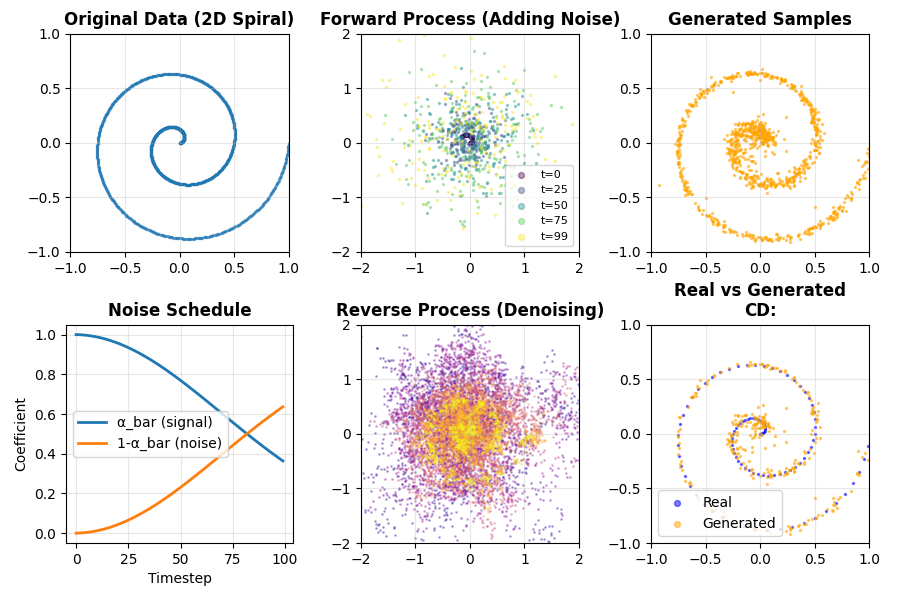

In [10]:
%matplotlib ipympl

# Static visualization
fig = visualize_results(model, data, alpha, alpha_bar, device)
plt.show()

### Animation

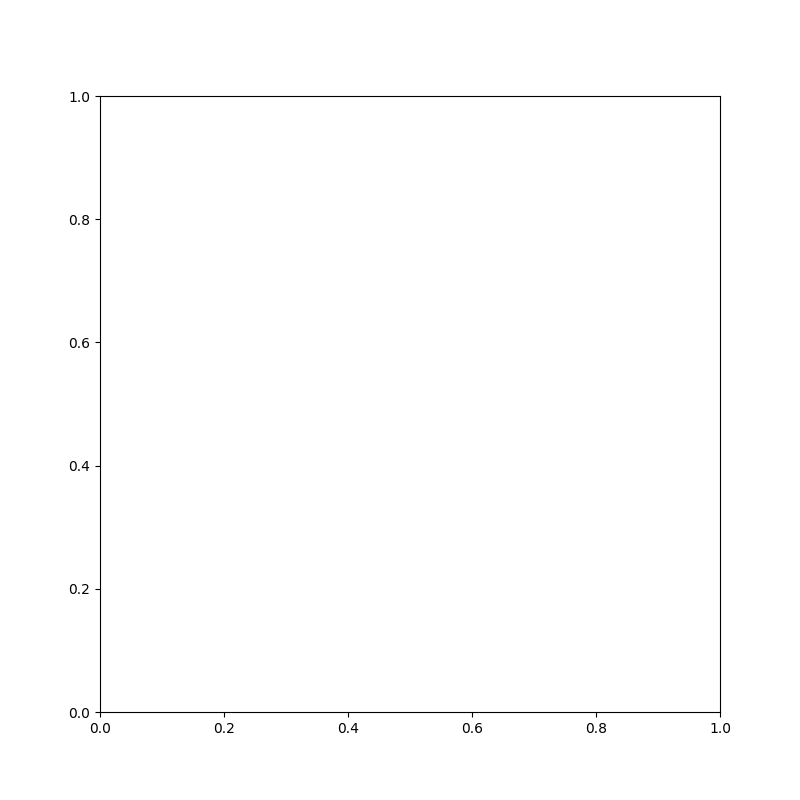

In [13]:
fig_anim, anim = create_animation(model, data, alpha, alpha_bar, device)
plt.show()